Missing values before handling:
Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

Missing values after handling:
Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

Duplicate count: 0 (preserved as per request)

Result column encoded:
Result
1    808
0    508
Name: count, dtype: int64

Removed 0 duplicate rows (before clustering)

Removed 528 outliers total using IQR method

[Elbow Method] Inertia untuk setiap k:
  k = 2: Inertia = 5927.44
  k = 3: Inertia = 5363.17
  k = 4: Inertia = 4893.12
  k = 5: Inertia = 4577.76
  k = 6: 

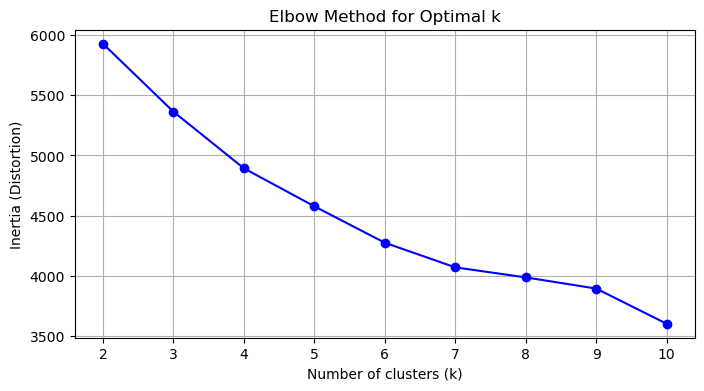


[Elbow] Rekomendasi k terbaik: 2 (berdasarkan penurunan inertia terbesar)

[Silhouette Method] Skor untuk setiap k:
  k = 2: Silhouette Score = 0.1739
  k = 3: Silhouette Score = 0.1317
  k = 4: Silhouette Score = 0.1480
  k = 5: Silhouette Score = 0.1452
  k = 6: Silhouette Score = 0.1472
  k = 7: Silhouette Score = 0.1399
  k = 8: Silhouette Score = 0.1368
  k = 9: Silhouette Score = 0.1174
  k = 10: Silhouette Score = 0.1332


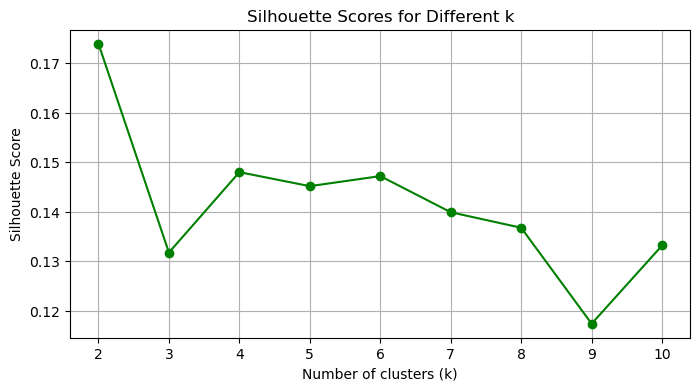


[Silhouette] Rekomendasi k terbaik: 2 (berdasarkan skor tertinggi)

[INFO] Final number of clusters selected: 2

Cluster Characteristics (Mean):
               Age    Gender  Heart rate  Systolic blood pressure  \
Cluster                                                             
0        60.339181  0.672515   74.500000               124.163743   
1        51.975336  0.587444   75.372197               126.784753   

         Diastolic blood pressure  Blood sugar     CK-MB  Troponin    Result  
Cluster                                                                       
0                       71.309942   128.257310  3.836693  0.042257  0.997076  
1                       72.251121   131.748206  2.560886  0.006605  0.002242  


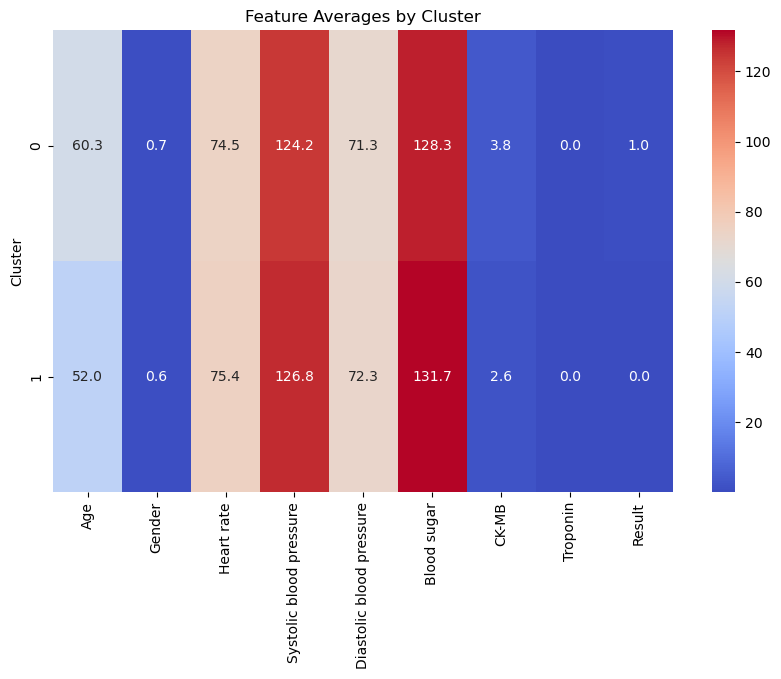

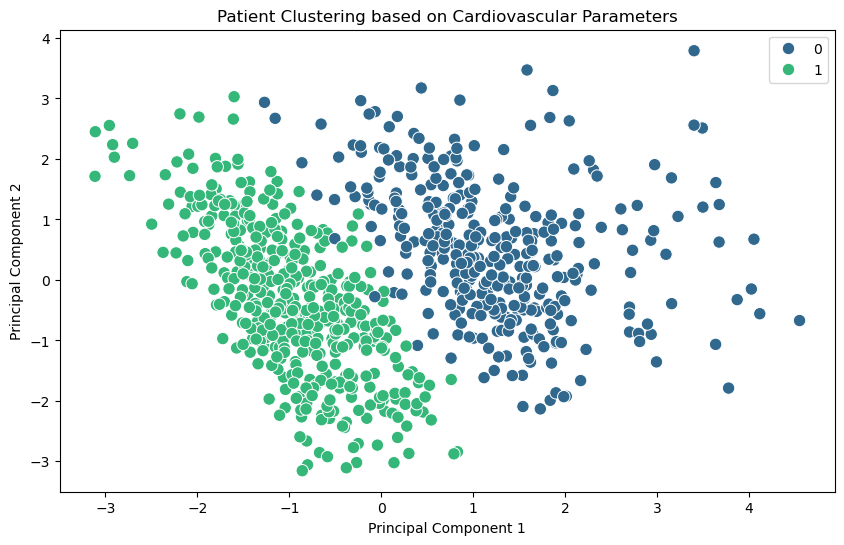

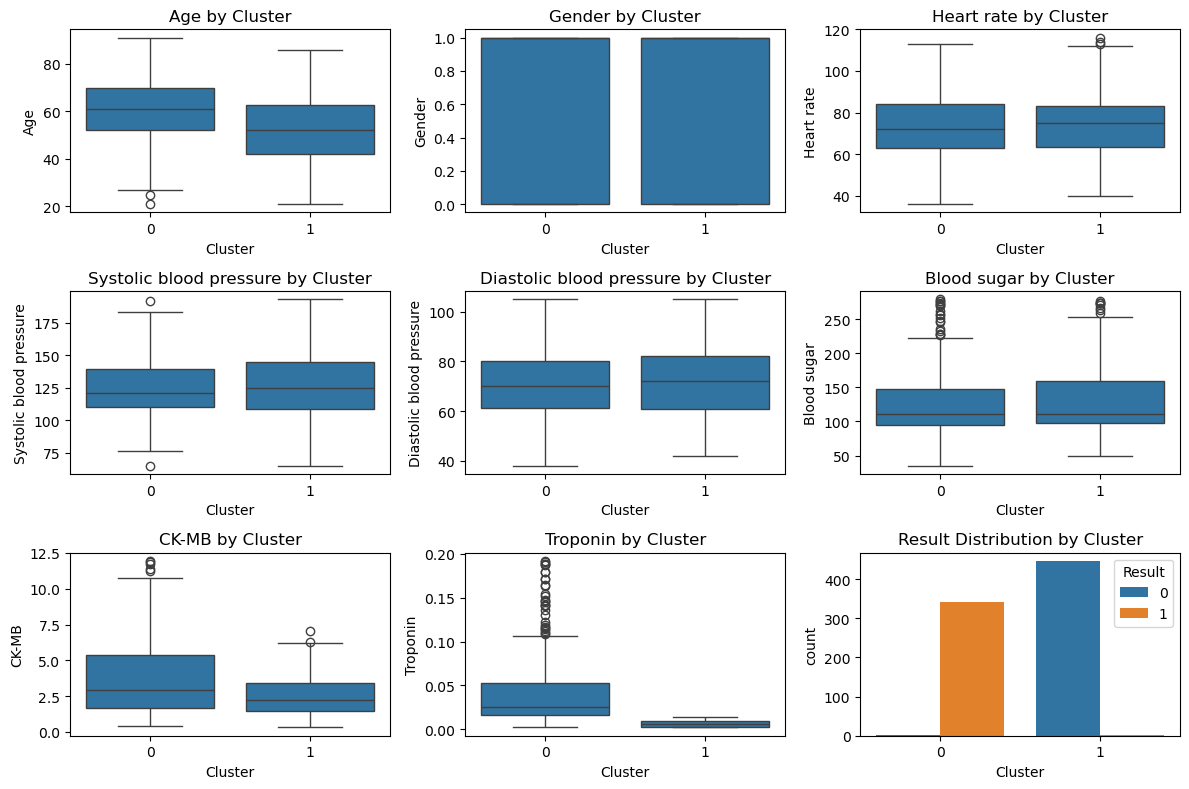


Process completed. Referral recommendations (without duplicates) saved to 'patient_referral_recommendations_without_duplicates.csv'


In [1]:
# Import library untuk manipulasi data, visualisasi, dan machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from typing import List, Dict


# Konstanta nama fitur yang digunakan dalam analisis
FEATURES = ['Age', 'Gender', 'Heart rate', 'Systolic blood pressure',
            'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin', 'Result']

# Label risiko berdasarkan cluster
RISK_LABELS = {0: '	Pasien dengan Penyakit Jantung', 1: 'Pasien Sehat / Normal'}

# Rekomendasi medis berdasarkan tingkat risiko
RECOMMENDATIONS = {
    0: 'Penanganan Medis Segera',
    1: 'Pemantauan Berkala',
}


def load_and_preprocess_data(filepath: str) -> pd.DataFrame:
    """Membaca dan melakukan preprocessing data: mengatasi missing value, konversi tipe, dan pembersihan."""
    df = pd.read_csv(filepath)

    # Tampilkan jumlah nilai kosong sebelum penanganan
    print("Missing values before handling:")
    print(df.isnull().sum())

    # Pisahkan kolom kategorikal dan numerik
    categorical_cols = ['Gender', 'Result']
    continuous_cols = [col for col in df.columns if col not in categorical_cols]

    # Hapus baris dengan nilai kosong di kolom kategorikal
    df = df.dropna(subset=categorical_cols)

    # Imputasi nilai kosong di kolom numerik dengan rata-rata
    for col in continuous_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)

    # Tampilkan nilai kosong setelah penanganan
    print("\nMissing values after handling:")
    print(df.isnull().sum())

    # Tampilkan jumlah duplikat (tidak dihapus di tahap ini)
    print(f"\nDuplicate count: {df.duplicated().sum()} (preserved as per request)")

    # Hapus data dengan detak jantung tidak realistis
    df = df[df['Heart rate'] < 220]

    # Konversi tipe data: Gender jadi int, Result diubah dari string ke 0/1
    df['Gender'] = df['Gender'].astype(int)
    df['Result'] = df['Result'].map({'negative': 0, 'positive': 1})

    # Tampilkan distribusi nilai kolom Result setelah encoding
    print("\nResult column encoded:")
    print(df['Result'].value_counts())

    return df


def remove_outliers_iqr(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Menghapus outlier dari kolom numerik menggunakan metode IQR."""
    original_size = df.shape[0]
    for col in cols:
        # Lewati kolom Result jika biner (0 dan 1)
        if col == 'Result' and set(df[col].unique()).issubset({0, 1}):
            continue
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df = df[df[col].between(lower, upper)]
    print(f"\nRemoved {original_size - df.shape[0]} outliers total using IQR method")
    return df


def analyze_clusters(df: pd.DataFrame, features: List[str]) -> None:
    """Menganalisis karakteristik masing-masing cluster secara statistik dan visual."""
    # Tampilkan rata-rata tiap fitur per cluster
    print("\nCluster Characteristics (Mean):")
    print(df.groupby('Cluster')[features].mean())

    # Visualisasi rata-rata fitur tiap cluster dalam bentuk heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.groupby('Cluster')[features].mean(),
                annot=True, cmap='coolwarm', fmt='.1f')
    plt.title("Feature Averages by Cluster")
    plt.show()


def visualize_pca_results(df: pd.DataFrame) -> None:
    """Visualisasi hasil clustering dalam 2D menggunakan PCA."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster',
                    data=df, palette='viridis', s=80)
    plt.title('Patient Clustering based on Cardiovascular Parameters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


def visualize_feature_distributions(df: pd.DataFrame, features: List[str]) -> None:
    """Visualisasi distribusi fitur untuk masing-masing cluster."""
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        if feature == 'Result':
            # Gunakan countplot untuk variabel biner
            sns.countplot(x='Cluster', hue=feature, data=df)
            plt.title(f'{feature} Distribution by Cluster')
        else:
            sns.boxplot(x='Cluster', y=feature, data=df)
            plt.title(f'{feature} by Cluster')
    plt.tight_layout()
    plt.show()


def plot_elbow(X: np.ndarray, max_k: int = 10) -> int:
    """Plot Elbow dan print nilai inertia untuk semua k."""
    distortions = []
    print("\n[Elbow Method] Inertia untuk setiap k:")
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        inertia = kmeans.inertia_
        distortions.append(inertia)
        print(f"  k = {k}: Inertia = {inertia:.2f}")

    # Hitung drop inertia terbesar
    #jumlah total jarak kuadrat antara tiap titik data dan pusat klasternya (centroid).
    inertia_drops = np.diff(distortions)
    k_best = np.argmin(inertia_drops) + 2

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k + 1), distortions, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

    print(f"\n[Elbow] Rekomendasi k terbaik: {k_best} (berdasarkan penurunan inertia terbesar)")
    return k_best




def plot_silhouette(X: np.ndarray, max_k: int = 10) -> int:
    """Plot Silhouette dan print skor untuk semua k."""
    scores = []
    print("\n[Silhouette Method] Skor untuk setiap k:")
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
        print(f"  k = {k}: Silhouette Score = {score:.4f}")

    k_best = np.argmax(scores) + 2

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k + 1), scores, 'go-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different k')
    plt.grid(True)
    plt.show()

    print(f"\n[Silhouette] Rekomendasi k terbaik: {k_best} (berdasarkan skor tertinggi)")
    return k_best




def main():
    # 1. Load dan preprocessing data
    df = load_and_preprocess_data("Medicaldataset.csv")

    # 2. Hapus data duplikat setelah preprocessing
    original_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"\nRemoved {original_rows - df.shape[0]} duplicate rows (before clustering)")

    # 3. Hapus outlier
    df = remove_outliers_iqr(df, FEATURES)

    # 4. Normalisasi fitur (scaling)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[FEATURES])

    # 5. Visualisasi & analisis untuk menentukan jumlah cluster terbaik
    k_elbow = plot_elbow(X_scaled, max_k=10)
    k_silhouette = plot_silhouette(X_scaled, max_k=10)

    # 6. Pilih jumlah cluster akhir (bisa dari elbow atau silhouette, atau manual override)
    num_clusters = k_silhouette  # atau k_elbow jika kamu ingin pakai inertia
    print(f"\n[INFO] Final number of clusters selected: {num_clusters}")

    # 7. Clustering dengan KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # 8. Hitung jarak ke centroid
    distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[df['Cluster']], axis=1)
    df['Distance_to_Centroid'] = distances

    # 9. Analisis tiap cluster
    analyze_clusters(df, FEATURES)

    # 10. Reduksi dimensi menggunakan PCA
    pca = PCA(n_components=2)
    df[['PCA1', 'PCA2']] = pca.fit_transform(X_scaled)
    visualize_pca_results(df)

    # 11. Mapping tingkat risiko dan rekomendasi
    df['Risk_Level'] = df['Cluster'].map(RISK_LABELS)
    df['Recommendation'] = df['Cluster'].map(RECOMMENDATIONS)

    # 12. Simpan hasil akhir ke file CSV
    output_cols = FEATURES + ['Risk_Level', 'Recommendation', 'Distance_to_Centroid']
    df[output_cols].to_csv('patient_referral_recommendations_without_duplicates.csv', index=False)

    # 13. Visualisasi distribusi tiap fitur berdasarkan cluster
    visualize_feature_distributions(df, FEATURES)

    print("\nProcess completed. Referral recommendations (without duplicates) saved to 'patient_referral_recommendations_without_duplicates.csv'")


if __name__ == "__main__":
    main()



=== Classification Report ===
                                precision    recall  f1-score   support

         Pasien Sehat / Normal       0.99      1.00      0.99        88
Pasien dengan Penyakit Jantung       1.00      0.99      0.99        70

                      accuracy                           0.99       158
                     macro avg       0.99      0.99      0.99       158
                  weighted avg       0.99      0.99      0.99       158

Accuracy Score: 0.9937


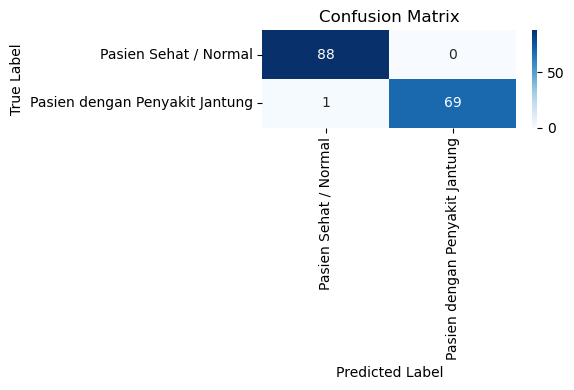

Model Decision Tree dan label encoder berhasil disimpan!


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

# Load dataset
file_path = 'patient_referral_recommendations_without_duplicates.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset tidak ditemukan: {file_path}")

df = pd.read_csv(file_path)

# Preprocessing
df = df.drop(['Recommendation', 'Distance_to_Centroid'], axis=1)

# Encode kolom Risk_Level
label_encoder = LabelEncoder()
df['Risk_Level'] = df['Risk_Level'].str.strip()
df['Risk_Level'] = label_encoder.fit_transform(df['Risk_Level'])

# Bagi dataset secara manual: 80% awal untuk train, 20% akhir untuk test
split_index = int(len(df) * 0.80)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Pisahkan fitur dan label
X_train = train_df.drop('Risk_Level', axis=1)
y_train = train_df['Risk_Level']
X_test = test_df.drop('Risk_Level', axis=1)
y_test = test_df['Risk_Level']

# Train model Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Simpan model dan label encoder
joblib.dump(model, 'heart_risk_model_dt.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Model Decision Tree dan label encoder berhasil disimpan!")


In [6]:
import joblib
import pandas as pd

# Load model dan encoder
model = joblib.load('/home/elliot/Documents/Semester 6/MachineLearning/HeartAttack/heart_risk_model_dt.pkl')
label_encoder = joblib.load('/home/elliot/Documents/Semester 6/MachineLearning/HeartAttack/label_encoder.pkl')

# Contoh data pasien (dari luar dataset training)
data_pasien = [
    [45, 1, 82, 135, 85, 160, 4.2, 0.06, 1],
    [28, 0, 75, 118, 76, 95, 2.5, 0.01, 0],
    [60, 1, 105, 150, 95, 190, 5.8, 0.12, 1],
    [33, 0, 70, 120, 80, 88, 3.0, 0.02, 0],
    [52, 1, 95, 142, 90, 145, 4.9, 0.07, 1]
]

# Buat DataFrame
df_input = pd.DataFrame(data_pasien, columns=[
    'Age', 'Gender', 'Heart rate', 'Systolic blood pressure',
    'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin', 'Result'
])

# Prediksi
predictions = model.predict(df_input)
probas = model.predict_proba(df_input)

# Tampilkan hasil
for i, (pred, proba) in enumerate(zip(predictions, probas), start=1):
    # Deteksi indeks kelas
    idx_sehat = list(model.classes_).index(label_encoder.transform(['Pasien Sehat / Normal'])[0])
    idx_penyakit = list(model.classes_).index(label_encoder.transform(['Pasien dengan Penyakit Jantung'])[0])

    prob_healthy = proba[idx_sehat] * 100
    prob_heart = proba[idx_penyakit] * 100


    print(f"\n📋 Pasien #{i}")
    print(f"Label Aktual: {'Penyakit Jantung' if df_input.loc[i-1, 'Result'] == 1 else 'Sehat'}")
    print(f"Hasil Prediksi: {label_encoder.inverse_transform([pred])[0]}")
    print(f"Probabilitas Pasien Sehat: {prob_healthy:.2f}%")
    print(f"Probabilitas Penyakit Jantung: {prob_heart:.2f}%")



📋 Pasien #1
Label Aktual: Penyakit Jantung
Hasil Prediksi: Pasien dengan Penyakit Jantung
Probabilitas Pasien Sehat: 0.00%
Probabilitas Penyakit Jantung: 100.00%

📋 Pasien #2
Label Aktual: Sehat
Hasil Prediksi: Pasien Sehat / Normal
Probabilitas Pasien Sehat: 100.00%
Probabilitas Penyakit Jantung: 0.00%

📋 Pasien #3
Label Aktual: Penyakit Jantung
Hasil Prediksi: Pasien dengan Penyakit Jantung
Probabilitas Pasien Sehat: 0.00%
Probabilitas Penyakit Jantung: 100.00%

📋 Pasien #4
Label Aktual: Sehat
Hasil Prediksi: Pasien Sehat / Normal
Probabilitas Pasien Sehat: 100.00%
Probabilitas Penyakit Jantung: 0.00%

📋 Pasien #5
Label Aktual: Penyakit Jantung
Hasil Prediksi: Pasien dengan Penyakit Jantung
Probabilitas Pasien Sehat: 0.00%
Probabilitas Penyakit Jantung: 100.00%
